Enable notebook to graph inline

In [4]:
%matplotlib notebook

Import dependancies.

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

Matplotlib settings.

In [6]:
plt.rcParams['figure.figsize'] = [20, 20]

Expansion specific global variables.

In [28]:
EXPANSION = 'NEO'
CSV_NAMES = {'MID':"game_data_public.MID.PremierDraft.csv",
             'NEO':"game_data_public.NEO.PremierDraft.csv"}

USER_WIN_RATE_BUCKET = {'MID':"user_win_rate_bucket",
                        'NEO':"user_game_win_rate_bucket"}
#To get information on new set use: df.info(max_cols=1106)

In [ ]:
df = pd.read_csv()

## Import 17lands data

Define data types for importing 17lands data.

In [10]:
MAX_MULLIGANS = 7
MAX_TURNS = 30

BASE_COLS = {
    'draft_id': str,
    'history_id': int,
    'time': str,
    'expansion': str,
    'format': str,
    'user_rank': str,
    'oppo_rank': str,
    'game_index': 'int8',
    'user_deck_colors': str,
    'oppo_deck_colors': str,
    'user_mulligans': 'int8',
    'oppo_mulligans': 'int8',
    'on_play': bool,
    'turns': 'int8',
    'won': bool,
    'missing_diffs': 'int8',
}

PER_TURN_COLS = {
    'cards_drawn': str,
    'cards_discarded': str,
    'lands_played': str,
    'cards_foretold': str,
    'creatures_cast': str,
    'non_creatures_cast': str,
    'user_instants_sorceries_cast': str,
    'oppo_instants_sorceries_cast': str,
    'user_abilities': str,
    'oppo_abilities': str,
    'user_cards_learned': str,
    'oppo_cards_learned': str,
    'creatures_attacked': str,
    'creatures_blocked': str,
    'creatures_unblocked': str,
    'creatures_blocking': str,
    'player_combat_damage_dealt': 'int8',
    'user_creatures_killed_combat': str,
    'oppo_creatures_killed_combat': str,
    'user_creatures_killed_non_combat': str,
    'oppo_creatures_killed_non_combat': str,
    'user_mana_spent': 'int8',
    'oppo_mana_spent': 'int8',
    'eot_user_cards_in_hand': str,
    'eot_oppo_cards_in_hand': str,
    'eot_user_lands_in_play': str,
    'eot_oppo_lands_in_play': str,
    'eot_user_creatures_in_play': str,
    'eot_oppo_creatures_in_play': str,
    'eot_user_non_creatures_in_play': str,
    'eot_oppo_non_creatures_in_play': str,
    'eot_user_life': 'int8',
    'eot_oppo_life': 'int8',
}

SUMMARY_COLS = {
    'cards_drawn': 'int8',
    'cards_discarded': 'int8',
    'lands_played': 'int8',
    'cards_foretold': 'int8',
    'creatures_cast': 'int8',
    'non_creatures_cast': 'int8',
    'instants_sorceries_cast': 'int8',
    'cards_learned': 'int8',
    'mana_spent': 'int16',
}

def get_dtypes():
    dtypes = BASE_COLS.copy()

    for x in range(1, MAX_MULLIGANS+1):
        dtypes[f'candidate_hand_{x}'] = str
    dtypes['opening_hand'] = str

    for turn in range(1, MAX_TURNS+1):
        for player in ['user', 'oppo']:
            for k, v in PER_TURN_COLS.items():
                dtypes[f'{player}_turn_{turn}_{k}'] = v
            dtypes[f'{player}_turn_{turn}_eot_oppo_cards_in_hand'] = 'int8'
        dtypes[f'oppo_turn_{turn}_cards_drawn'] = 'int8'

    for player in ['user', 'oppo']:
        for col in SUMMARY_COLS:
            dtypes[f'{player}_total_{col}'] = 'int8'

    return dtypes

Load 17lands data into dataframe.

In [11]:
dtypes=get_dtypes()
df = pd.read_csv(CSV_NAMES[EXPANSION], dtype=dtypes)

In [25]:
df.info(max_cols=1168)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630450 entries, 0 to 630449
Data columns (total 1167 columns):
 #     Column                                       Non-Null Count   Dtype  
---    ------                                       --------------   -----  
 0     expansion                                    630450 non-null  object 
 1     event_type                                   630450 non-null  object 
 2     draft_id                                     630450 non-null  object 
 3     draft_time                                   630450 non-null  object 
 4     build_index                                  630450 non-null  int64  
 5     match_number                                 630450 non-null  int64  
 6     game_number                                  630450 non-null  int64  
 7     rank                                         607969 non-null  object 
 8     opp_rank                                     627668 non-null  object 
 9     main_colors                      

# Helper functions

Find decks based on provided parameters.
- `cards`: Contains specified card(s) (eg. `"Siege Zombie"`, `["Siege Zombie", "Diregraf Horde"]`).
- `win_rate`: Contains decks with win rates greater than or equal to value (eg. `0.6`).
- `cp`: Contains deck with provided primary color pair (eg. `'UW'`).

In [49]:
def find_decks(cards=None, win_rate=None, cp=None):
    decks = df
    #select decks that contain specified card(s)
    if (cards):
        for card in cards:
            decks = decks[decks['deck_' + card] > 0]
    #if winrate is provided, filter by wr
    if (win_rate):
        decks = decks[decks[USER_WIN_RATE_BUCKET[EXPANSION]] >= win_rate]
    #select decks that contain specified color pairing
    if (cp):
        decks = decks[decks['main_colors'] == cp]
    #select just deck information
    decks = decks.filter(regex='deck_*', axis=1)
    return decks

Create scatter plot of decks. Returns DataFrame that is shape (n, 2).

In [30]:
def graph_scatter(decks, df=df):
    # define transform
    svd = TruncatedSVD()
    # prepare transform on dataset
    svd.fit(decks)
    # apply transform to dataset
    transformed = svd.transform(decks)
    #change to a DataFrame, fixing labels for t
    t = pd.DataFrame(data=transformed, columns=['a','b'], index=decks.index)
    #C parameter is the winrate of deck
    plt.scatter(t['a'], t['b'], c=df.loc[decks.index,USER_WIN_RATE_BUCKET[EXPANSION]], cmap='RdBu_r')
    plt.grid(which='major', linestyle='-')
    plt.grid(which='minor', linestyle='--')
    plt.minorticks_on()
    return t

Dimensionality reduction using kurtosis-based projection pursuit: https://github.com/S-Driscoll/Projection-pursuit

In [31]:
from projpursuit import projpursuit
def graph_scatter_ppa(decks, df=df):
    transformed = projpursuit(decks, Meth='Mul', CenMeth='Rec', MaxMin='Min')
    print(transformed.head())

Show a list of the average number of cards within a given cluster of transform 't' defined by the boundries amin, amax, bmin and bmax.

In [32]:
def card_avgs(decks, t, amin, amax, bmin, bmax, num_cards=50):
    #find decks within the boundries
    t = t[t['a']>amin]
    t = t[t['a']<amax]
    t = t[t['b']>bmin]
    t = t[t['b']<bmax]
    #pull out the corresponding rows from decks
    quad = decks.loc[t.index]
    #remove any columns with all zeros
    quad = quad.loc[:, (quad != 0).any(axis=0)]
    #find average number of cards within all decks
    all_avgs = decks.loc[:, quad.columns].mean()
    print(f'{quad.shape[0]} decks in area. With average win rate of {df.loc[quad.index][USER_WIN_RATE_BUCKET[EXPANSION]].mean() * 100}%')
    #take the mean of each column and then find the ratio of card average in quad vs entire sample
    quad = quad.mean()
    quad = pd.concat([quad, quad/all_avgs], axis=1, keys=['Average', 'Synergy'])
    #sort by highest average of cards
    quad = quad.sort_values(by='Average', ascending=False)
    print(quad.head(num_cards))
    #graph histogram
    #plt.hist(deck, orientation='horizontal')
    #sns.displot(deck.head(), x=deck.head().index, orientation='horizontal')


# Analysis

Use the below cells to analyze decks!

In [50]:
decks = find_decks(cards=["Atsushi, the Blazing Sky"])

Red dots are higher win rates whereas blue are lower.

<IPython.core.display.Javascript object>


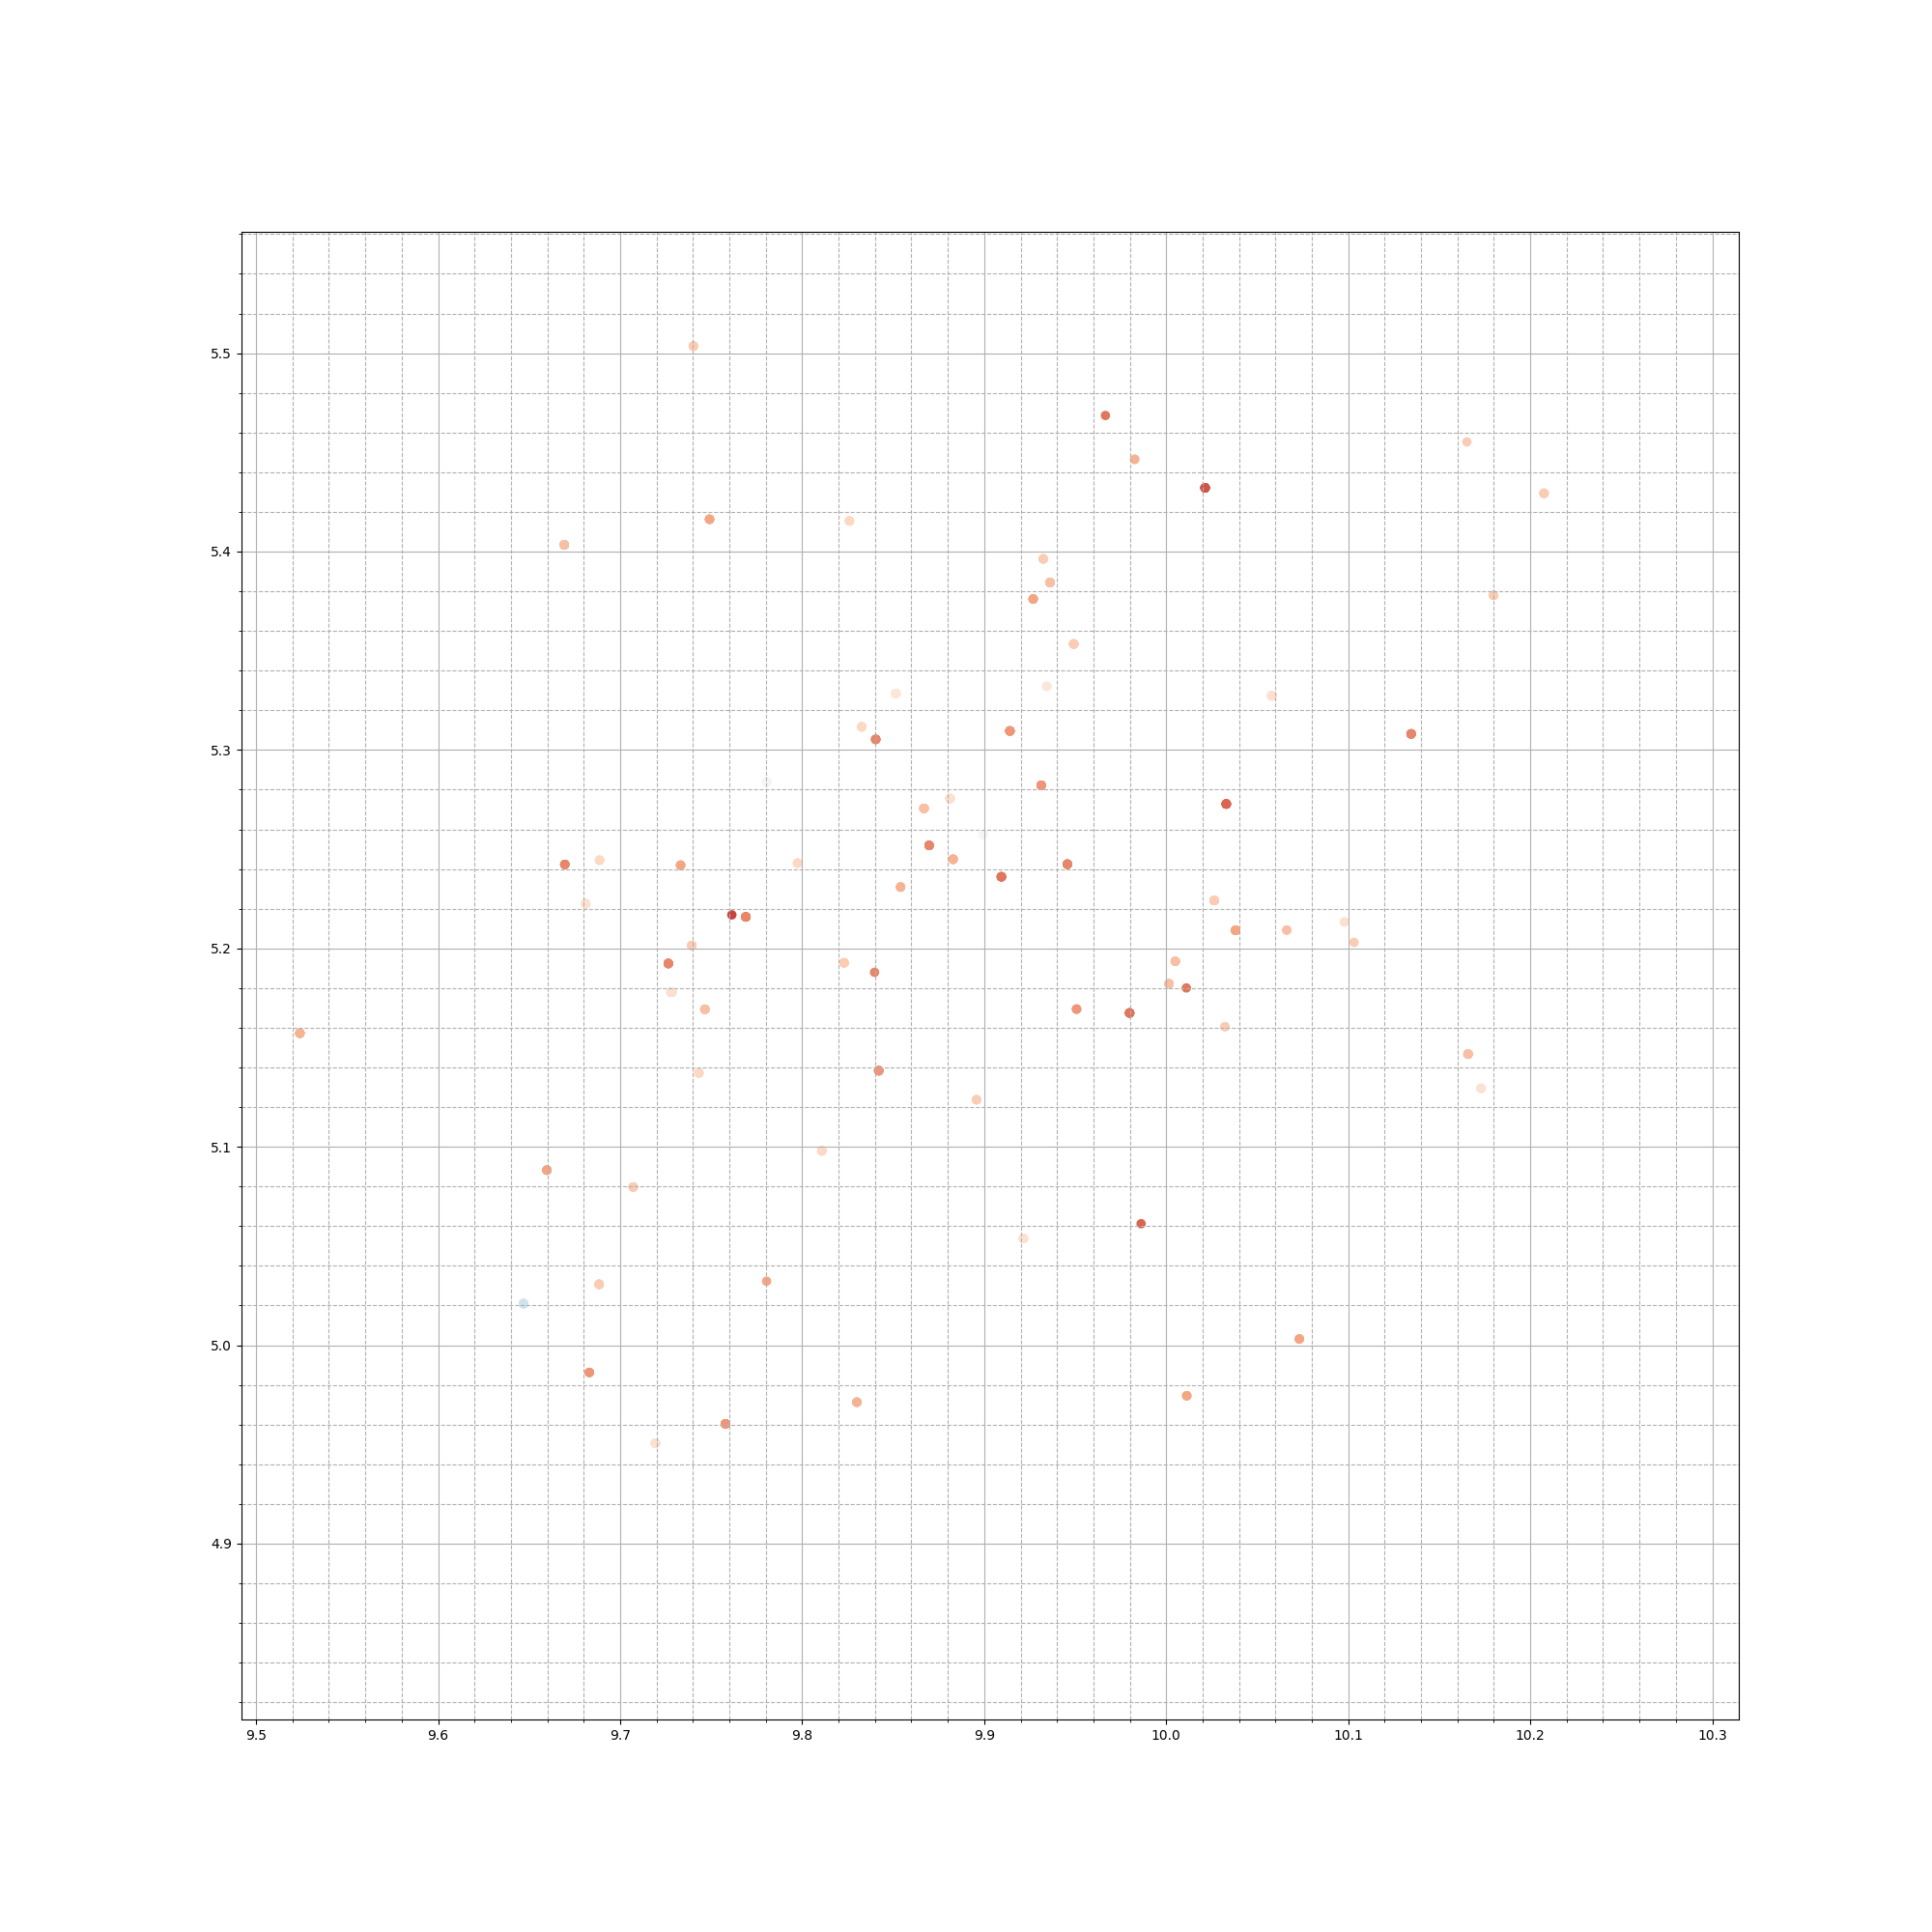

In [52]:
t = graph_scatter(decks)

In [54]:
card_avgs(decks, t, 9.5, 10.3, 4.9, 5.5)

400 decks in area. With average win rate of 56.545%
                                 Average   Synergy
deck_Mountain                     8.0000  1.113821
deck_Swamp                        7.0025  2.684657
deck_Atsushi, the Blazing Sky     1.0025  1.002024
deck_Experimental Synthesizer     0.9950  1.537860
deck_Towashi Songshaper           0.9625  1.722291
deck_Voltage Surge                0.9450  1.381477
deck_Simian Sling                 0.9100  1.522742
deck_Kami's Flare                 0.7975  1.219890
deck_Virus Beetle                 0.7950  3.068927
deck_Okiba Reckoner Raid          0.7525  3.112600
deck_Unstoppable Ogre             0.7175  1.873294
deck_Ironhoof Boar                0.5900  1.218068
deck_Oni-Cult Anvil               0.5625  2.530529
deck_Bloodfell Caves              0.5550  3.406697
deck_Lethal Exploit               0.5400  3.017293
deck_Chainflail Centipede         0.4750  3.401582
deck_Sokenzan Smelter             0.4700  1.840658
deck_Mukotai Ambusher         